<h1>Using statsmodels.sandbox.distributions.copula </h1>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import beta, lognorm, kendalltau, pearsonr, spearmanr, norm
from scipy.optimize import fmin
from scipy.integrate import quad
from scipy.special import expm1

from statsmodels.sandbox.distributions.copula import CopulaBivariate, \
copula_bv_archimedean, TransfGumbel

import sys


"""copulanames = {'indep' : copula_bv_indep,
               'i' : copula_bv_indep,
               'min' : copula_bv_min,
               'max' : copula_bv_max,
               'clayton' : copula_bv_clayton,
               'cookjohnson' : copula_bv_clayton,
               'cj' : copula_bv_clayton,
               'frank' : copula_bv_frank,
               'gauss' : copula_bv_gauss,
               'normal' : copula_bv_gauss,
               't' : copula_bv_frank}
"""

plt.style.use('ggplot')


In [13]:
#Methods for fitting copula parameters 
#borrowed from the copulalib package and compressed a bit :)

# === Frank parameter fit
def frank_fun(alpha,kTau=0):
    """
    optimization of this function will give the parameter 
    for the frank copula
    """
    #Integrand for the first order debye function
    integrand_debye = lambda t: t/(np.exp(t)-1.) #expm1(t) instead of exp(t)-1.
    #First order Debye functio
    debye = lambda alpha: quad(integrand_debye, 
                               sys.float_info.epsilon, 
                               alpha
                              )[0]/alpha
    diff = (1.-kTau)/4.0-(debye(-alpha)-1.)/alpha
    return diff**2
    
def theta_Frank(kTau):
    return -fmin(frank_fun, -5., args=(kTau), disp=False)[0] 

#================
#tiny clayton parameter method
def theta_Clayton(kTau):
    try:
        return 2.*kTau/(1.-kTau)
    except Exception as ohno: 
        print "Problems getting Theta for Clayton \
               {}:{}".format(type(ohno), ohno.message)

#tiny Gumbel parameter method
def theta_Gumbel(kTau):
    try:
        return 1./(1.-kTau)
    except Exception as ohno: 
        print "Problems getting Theta for Gumbel \
               {}:{}".format(type(ohno), ohno.message)

#================
#copula generators
def gaussiancopula(x,y,P):
    #get covariance matrix P
    #x1=norm.ppf(x,loc=0,scale=1)
    #y1=norm.ppf(y,loc=0,scale=1)
    #return norm.cdf((x1,y1),loc=0,scale=P)
    return x*y*0.5

def gumbelcopula(x,y,transform,theta):
    print "entering gumbel {}".format(transform)
    return copula_bv_archimedean(x,y,transform,[theta])

In [30]:
#================
#copula plotter
def plot3d(x,y,z,label=None, xlabel=None, ylabel=None, color='b',show=False):
    assert len(x)==len(y)==len(z), "Cant 3dplot. At least one dimension \
    differs in shape x{}-y{}-z{}".format(len(x),len(y),len(z))
    fig = pylab.figure()
    ax = Axes3D(fig)
    ax.scatter(x,y,z,c=color)
    if label != None:
        ax.text2D(0.05, 0.95, label, transform=ax.transAxes)
        ax.set_xlabel('X: {}'.format(xlabel))
        ax.set_ylabel('Y: {}'.format(ylabel))
        ax.set_zlabel('Copula family: {}'.format(label))
    if show:
        try:
            plt.show()
        except:
            print "could not plot {}".format(label)
            return
    return [fig,ax]

def buildPlotManyCopulas(copulaDict,U,V,xlabel,ylabel,sample, plot=False):
    #sample is a list of indices from U,V. So that we dont
    #plot the whole copula.
    if plot:
        %matplotlib notebook
    returnable={}
    for copulaName in copulaDict:
        try:
            copargs=copulaDict[copulaName]
            print '{} args: {}'.format(copulaName,copargs)
        except:
            print "could not get arguments for copula {}".format(copulaName)
            continue
        try:
            bivcopula=CopulaBivariate((U,V),copulaName,copargs=copargs)
            print "good, we build {} copula with args \
            {}".format(copulaName, copargs)
        except Exception as why:
            print "could not build copula for {} \
                   because {}:{}".format(copulaName,type(why),why.message)
            continue

        try:
            copulapoints=bivcopula.copula(U, V,*copargs)
        except Exception as bb:
            print "attempting parameterless copula for {}".format(copulaName)
            try:
                copulapoints=bivcopula.copula(U, V)
            except Exception as why:
                print "could not plot copula for {} because {}:{} ".format(copulaName,type(why),why.message)
                continue

        print "Plotting a sample of copula {}".format(copulaName)
        returnable[copulaName]=copulapoints
        if plot:
            zeFigure=plot3d(U[sample],V[sample],copulapoints[sample], label=copulaName,  
                        xlabel=xlabel,ylabel=ylabel)[0] #now do a 3d plot of the copula
            zeFigure.show()
    return returnable

<h1>The following cell is for generating some input data</h1>

For this example we are using the same distributions as in the previous notebook for exploring copula paclages. If you wished to adapt this code to your own real data, feel free to go to the "miscellaneous" section at the bottom of the notebook, and use the the code in there :).

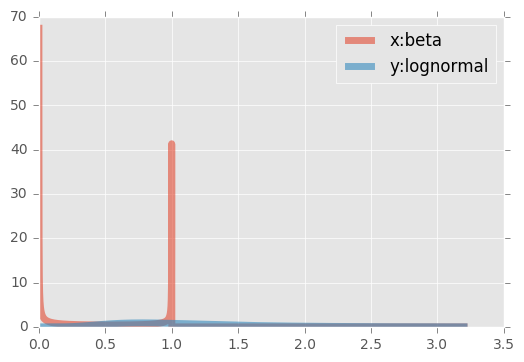

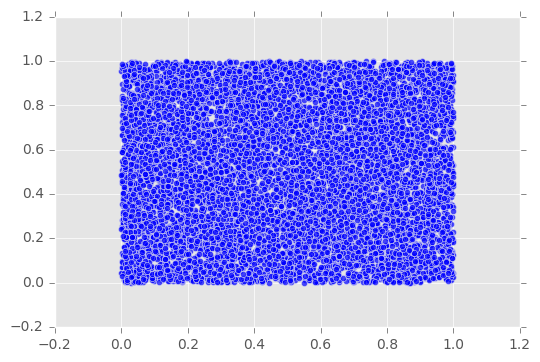

In [15]:
xlabel='xlabel'
ylabel='ylabel'
sz=10000
loc=0.0
sc=0.5
a=0.25#2. #alpha
b=0.35#5. #beta
t = np.linspace(0, lognorm.ppf(0.99, sc), sz)
plt.plot(t, beta.pdf(t,a,b), lw=5, alpha=0.6, label='x:beta')
plt.plot(t, lognorm.pdf(t, sc), lw=5, alpha=0.6, label='y:lognormal')
plt.legend()
plt.show()
#some samples from some df
X=beta.rvs(a,b,size=sz)
Y=lognorm.rvs(sc,size=sz)
#Uniform marginals by applying CDF to the values in sample
U=beta.cdf(X,a,b)
V=lognorm.cdf(Y,sc)

#plot them to visually check for independence
plt.scatter(U,V,marker='o',alpha=0.7)
plt.show()

kTau=kendalltau(X, Y)[0]

<h1>Visualising Copulas</h1>

An interesting feature of the StatsModels copula package, is that the constructor "CopulaBivariate" accepts either a copula name or a callable. So you can simply pass either one of them. 

There is no direct constructor to gaussian or t copula, and I guess you could build a more generic function for elliptic copulas. But for the sake of testing things, we can abuse of python a bit. **Hold my beer, check this out** : 

frank args: [0.00604248046875]
good, we build frank copula with args             [0.00604248046875]
Plotting a sample of copula frank


<IPython.core.display.Javascript object>


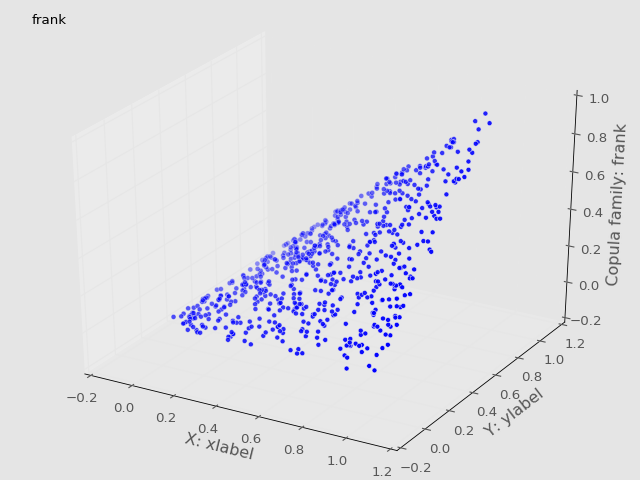

max args: []
good, we build max copula with args             []
Plotting a sample of copula max


<IPython.core.display.Javascript object>


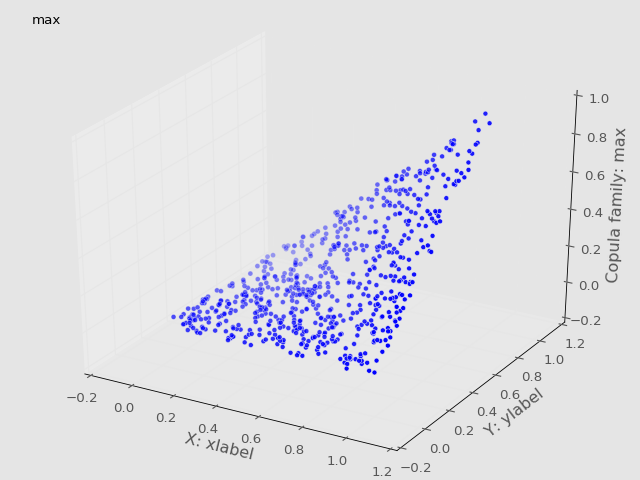

min args: []
good, we build min copula with args             []
Plotting a sample of copula min


<IPython.core.display.Javascript object>


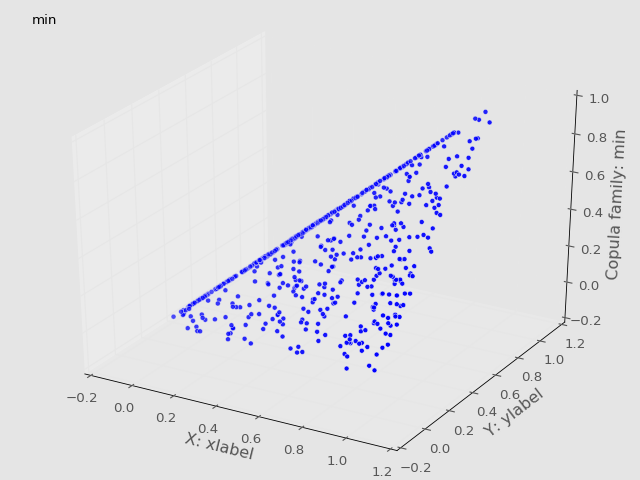

<function gumbelcopula at 0x7f58fd7e0398> args: (<statsmodels.sandbox.distributions.copula.TransfGumbel object at 0x7f58fcf276d0>, 1.0060471492916014)
entering gumbel <statsmodels.sandbox.distributions.copula.TransfGumbel object at 0x7f58fcf276d0>
good, we build <function gumbelcopula at 0x7f58fd7e0398> copula with args             (<statsmodels.sandbox.distributions.copula.TransfGumbel object at 0x7f58fcf276d0>, 1.0060471492916014)
entering gumbel <statsmodels.sandbox.distributions.copula.TransfGumbel object at 0x7f58fcf276d0>
Plotting a sample of copula <function gumbelcopula at 0x7f58fd7e0398>


<IPython.core.display.Javascript object>


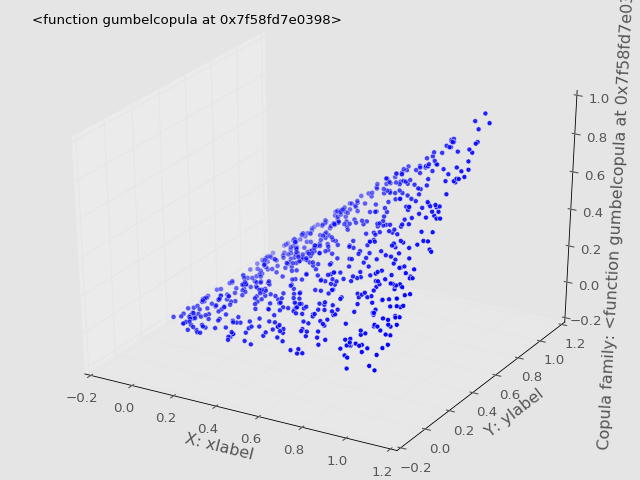

clayton args: [0.012094298583203086]
good, we build clayton copula with args             [0.012094298583203086]
Plotting a sample of copula clayton


<IPython.core.display.Javascript object>


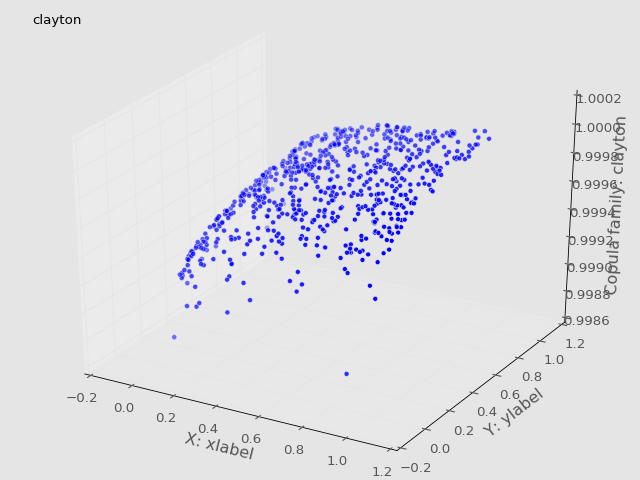

In [31]:
plotSamples=700
#select indices for sampling the copula
sample=np.random.choice(range(len(U)),plotSamples)

copulaDict={
            'frank': [theta_Frank(kTau)],
            'clayton':[theta_Clayton(kTau)],
             gumbelcopula:(TransfGumbel(),theta_Gumbel(kTau)),
            #'indep': [],
            'min' : [],
            'max' : [],
            #gaussiancopula: [np.cov(X,Y)] 
            }

copulapoints=buildPlotManyCopulas(copulaDict,U,V,xlabel,ylabel,sample, 
                                  plot=True)


<h1>Visualising Frechét-Höffding Bounds</h1>

<p>Following theorem 7.8 of <a href=https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_07.pdf>this slides at qrmtutorial.org</a>, we plotted together the comonotone and countermonotone copulas, which give us the Frechét-Höffding bounds. Voilá!</p>

<IPython.core.display.Javascript object>


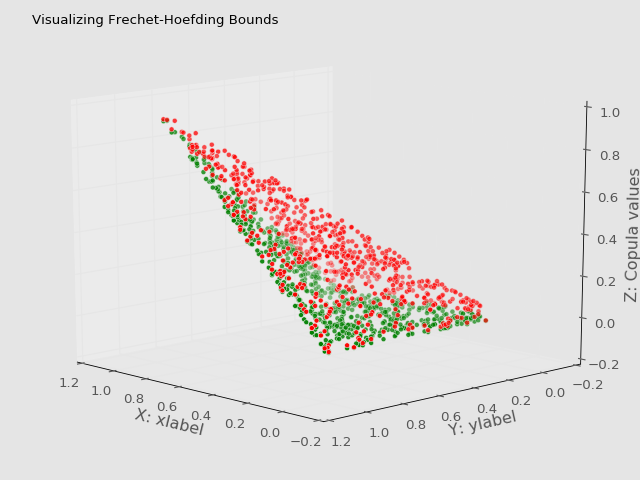

In [32]:
#now, attempt to build the region bounding the copulas
%matplotlib notebook
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(U[sample],V[sample],copulapoints['min'][sample],
          c='red') #upper bound (M(u) comonotonic copula)
ax.scatter(U[sample],V[sample],copulapoints['max'][sample],
           c='green') #lower bound (W(u) countermonotonic copula)
ax.text2D(0.05, 0.95, 'Visualizing Frechet-Hoefding Bounds', transform=ax.transAxes)
ax.set_xlabel('X: {}'.format(xlabel))
ax.set_ylabel('Y: {}'.format(ylabel))
ax.set_zlabel('Z: Copula values')
fig.show()

<h1> Miscellaneous</h1>
<p>Use this in the cell for fetching input data if you wish to plug in your own csv.</p>

In [ ]:
#input for csvs. Use in the cell for fetching input data
sys.path.append('a path where you have some miscelaneus helpers')
from miscHelpers import getData # some helper method for converting a csv into a dictionary
from statsmodels.distributions.empirical_distribution import ECDF

datadict=getData('path\\file.csv')
print datadict.keys()
xlabel='label' #labels
ylabel='label'   #labels
X=np.array(datadict[xlabel])
Y=np.array(datadict[ylabel])
#Uniform marginals by applying the empirical CDF to sample values
Xecdf=ECDF(X,side='right') #default side is rightsided [a,b)
Yecdf=ECDF(Y,side='right')
U=Xecdf(X)
V=Yecdf(Y)
%matplotlib inline
plt.scatter(U,V,marker='o',alpha=0.7)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

kTau=kendalltau(X, Y)[0]
